<a href="https://colab.research.google.com/github/zaina-ali/-bigquery-sql-quiz/blob/main/Another_copy_of_cloud_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langdetect
from langdetect import detect


In [ ]:
!pip install firebase-admin  # Run this once (if not installed)

In [ ]:
import firebase_admin
from firebase_admin import credentials, firestore, storage

# Initialize Firebase (replace with your service account path)
cred = credentials.Certificate("sentimentm.json")  # Download from Firebase Console
firebase_admin.initialize_app(cred, {
    'storageBucket': "ssentiment-708b8.appspot.com"  # Find this in Firebase → Storage → Files
})

# Get Firestore and Storage instances
db = firestore.client()
bucket = storage.bucket()

In [ ]:
import requests
import time
from getpass import getpass
import requests
import time

API_KEY = getpass('Enter your NewsAPI key: ')
QUERY = "bitcoin"
PAGE_SIZE = 100  # max articles per page
MAX_ARTICLES = 299

all_articles = []
page = 1

# First request to get totalResults
url = f"https://newsapi.org/v2/everything?q={QUERY}&pageSize={PAGE_SIZE}&page={page}&apiKey={API_KEY}"
response = requests.get(url)
data = response.json()

total_results = data.get("totalResults", 0)
print(f"Total articles available: {total_results}")

# Adjust max articles to the minimum of requested or available
max_to_fetch = min(MAX_ARTICLES, total_results)

while len(all_articles) < max_to_fetch:
    url = f"https://newsapi.org/v2/everything?q={QUERY}&pageSize={PAGE_SIZE}&page={page}&apiKey={API_KEY}"
    response = requests.get(url)
    data = response.json()

    articles = data.get("articles", [])
    if not articles:
        break  # no more articles

    all_articles.extend(articles)
    print(f"Fetched {len(all_articles)} articles so far...")

    if len(all_articles) >= max_to_fetch:
        break

    page += 1
    time.sleep(1)  # polite delay to avoid hitting API rate limits

print(f"Total articles fetched: {len(all_articles)}")

Enter your NewsAPI key: ··········
Total articles available: 12129
Fetched 99 articles so far...
Total articles fetched: 99


In [ ]:
from pyspark.sql import SparkSession

# Initialize SparkSession if not already
spark = SparkSession.builder.appName("news_sentiment_analysis").getOrCreate()

# Convert list of dicts to Spark DataFrame
combined_df = spark.createDataFrame(all_articles)

# Now you can use combined_df.show(), combined_df.columns, etc.
combined_df.show(10, truncate=False)

+------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+--------------------------------------------------+-------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|author

we've loaded, combined, and previewed

In [ ]:
# Show column names
print("Columns:", combined_df.columns)

# Show data types and structure
combined_df.printSchema()

Columns: ['author', 'content', 'description', 'publishedAt', 'source', 'title', 'url', 'urlToImage']
root
 |-- author: string (nullable = true)
 |-- content: string (nullable = true)
 |-- description: string (nullable = true)
 |-- publishedAt: string (nullable = true)
 |-- source: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- urlToImage: string (nullable = true)



In [ ]:
from pyspark.sql.functions import col, lower, regexp_replace

# Clean title, description, and content
cleaned_df = combined_df.withColumn("clean_description", lower(regexp_replace(col("description"), "[^a-zA-Z0-9\s.,!?]", "")))\
    .withColumn("clean_description", lower(regexp_replace(col("description"), "[^a-zA-Z0-9\s]", ""))) \
    .withColumn("clean_content", lower(regexp_replace(col("content"), "[^a-zA-Z0-9\s]", "")))

🔹 Why? To remove Arabic or other-language articles so your sentiment results are correct.


In [ ]:
# Drop rows with empty or null clean_description
cleaned_df = cleaned_df.filter(col("clean_description").isNotNull() & (col("clean_description") != ""))

In [ ]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType
# UDF for language detection
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

detect_language_udf = udf(detect_language, StringType())
cleaned_df = cleaned_df.withColumn("lang", detect_language_udf(col("clean_description")))

In [ ]:
# Cache the DataFrame here to save the detected languages results in memory
cleaned_df = cleaned_df.cache()

In [ ]:
print("🔹 Detected languages and their counts:")
cleaned_df.groupBy("lang").count().show()

🔹 Detected languages and their counts:
+-------+-----+
|   lang|count|
+-------+-----+
|     en|   61|
|     de|   13|
|     es|    7|
|     fr|    4|
|unknown|    1|
+-------+-----+



In [ ]:
# Count English before filtering
english_before_filter = cleaned_df.filter(col("lang") == "en").count()
print(f"English before filtering: {english_before_filter}")

English before filtering: 61


In [ ]:
cleaned_df = cleaned_df.filter(col("lang") == "en")

In [ ]:
total_after = cleaned_df.count()
print(f"🔹 Total articles after keeping only English: {total_after}")
cleaned_df.groupBy("lang").count().show()

🔹 Total articles after keeping only English: 61
+----+-----+
|lang|count|
+----+-----+
|  en|   61|
+----+-----+



In [ ]:
print("Columns:", cleaned_df.columns)
cleaned_df.select("title", "description", "clean_description","lang").show(5, truncate=False)

Columns: ['author', 'content', 'description', 'publishedAt', 'source', 'title', 'url', 'urlToImage', 'clean_description', 'clean_content', 'lang']
+-------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+
|title                                                                                                  |description                                                                                                             

# distilBERT

In [ ]:
!pip install -q transformers
from transformers import pipeline

loading distilbert model :

In [ ]:
from pyspark.sql.functions import when

cleaned_df = cleaned_df.withColumn(
    "text_for_sentiment",
    when(col("clean_description").isNotNull() & (col("clean_description") != ""), col("clean_description"))
    .otherwise(col("description"))
)

In [ ]:
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


defining the function to get sentiment

In [ ]:
def get_sentiment(text):
    if text:
        try:
            result = sentiment_analyzer(text[:512])[0]
            return (result['label'], float(result['score']))
        except:
            return ("UNKNOWN", 0.0)
    else:
        return ("EMPTY", 0.0)

create UDFs and apply them

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, FloatType

get_sentiment_label_udf = udf(lambda x: get_sentiment(x)[0], StringType())
get_sentiment_score_udf = udf(lambda x: get_sentiment(x)[1], FloatType())

sentiment_df = cleaned_df.withColumn("sentiment_label", get_sentiment_label_udf(col("text_for_sentiment"))) \
                         .withColumn("sentiment_score", get_sentiment_score_udf(col("text_for_sentiment")))

In [ ]:
sentiment_df.select("title", "sentiment_label", "sentiment_score").show(10, truncate=False)
sentiment_df.groupBy("sentiment_label").count().show()

+------------------------------------------------------------------------------------------------------------+---------------+---------------+
|title                                                                                                       |sentiment_label|sentiment_score|
+------------------------------------------------------------------------------------------------------------+---------------+---------------+
|American Bitcoin To Go Public: Key Details On Trump Family-Backed ABTC                                      |NEGATIVE       |0.99661547     |
|ARK Invest Raises 2030 Bitcoin Price Target to as High as $2.4M in Bullish Scenario                         |NEGATIVE       |0.9900087      |
|Serious BlackRock Bitcoin Warning Fuels ‘Disaster’ Fears As The Price Suddenly Dives                        |NEGATIVE       |0.5000525      |
|‘Changing Fast’—Bitcoin Is Suddenly Braced For A $10 Trillion Wall Street ETF Price Boom                    |POSITIVE       |0.9979982      |

In [ ]:
sentiment_pd = sentiment_df.select("title", "description","clean_description", "sentiment_label", "sentiment_score").toPandas()
sentiment_pd.to_csv("distilbert_sentimentt.csv", index=False)

# **finBERT**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col # Make sure col is imported

spark = SparkSession.builder.appName("finbert_session").getOrCreate()

# Use cleaned_df from before, with only title and clean_description
rdd = cleaned_df.select("title", "clean_description").rdd

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import numpy as np

# Load finBERT model and tokenizer once globally
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def analyze_partition(partition):
    results = []
    for row in partition:
        title = row['title']
        text = row['clean_description']
        if not text:
            results.append((title, text, None, 0.0))
            continue

        # Tokenize the input text
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

        # Predict sentiment with no gradient calculation
        with torch.no_grad():
            outputs = model(**inputs)
            scores = outputs.logits.softmax(dim=1).cpu().numpy()[0]

        labels = ["neutral", "positive", "negative"]
        max_idx = np.argmax(scores)
        label = labels[max_idx]
        score = float(scores[max_idx])

        results.append((title, text, label, score))
    return iter(results)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [ ]:
result_rdd = rdd.mapPartitions(analyze_partition)

In [ ]:
# Define schema and convert RDD to DataFrame
from pyspark.sql.types import StructType, StructField, StringType, FloatType

schema = StructType([
    StructField("title", StringType(), True),
    StructField("clean_description", StringType(), True),
    StructField("finbert_label", StringType(), True),
    StructField("finbert_score", FloatType(), True),
])

finbert_df = spark.createDataFrame(result_rdd, schema=schema)

In [ ]:
# Show results
finbert_df.select("title", "finbert_label", "finbert_score").show(30, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+-------------+
|title                                                                                                                                                  |finbert_label|finbert_score|
+-------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+-------------+
|19-Year-Old to Plead Guilty to Hacking Charges After Data Breach of Millions of Schoolchildren                                                         |neutral      |0.9969463    |
|Bitcoin price holds above $102,000 as BlackRock leads fund inflows                                                                                     |neutral      |0.9999635    |
|Jamie Dimon opens the door to bitcoin, warns against stagflation in wide-ranging remarks 

# comparison

In [ ]:
from pyspark.sql.functions import col

sentiment_df = spark.read.option("header", "true").csv("distilbert_sentimentt.csv")
sentiment_df = sentiment_df.withColumn("sentiment_score", col("sentiment_score").cast("float"))

In [ ]:
# Join on 'title' (assuming title is unique and consistent)
BERTs = sentiment_df.join(
    finbert_df.select("title", "finbert_label", "finbert_score"),
    on="title",
    how="inner"
)

In [ ]:
BERTs.select("title", "sentiment_label", "sentiment_score", "finbert_label", "finbert_score").show(20, truncate=False)

+------------------------------------------------------------------------------------------------------------+---------------+---------------+-------------+-------------+
|title                                                                                                       |sentiment_label|sentiment_score|finbert_label|finbert_score|
+------------------------------------------------------------------------------------------------------------+---------------+---------------+-------------+-------------+
|American Bitcoin To Go Public: Key Details On Trump Family-Backed ABTC                                      |NEGATIVE       |0.99661547     |neutral      |0.9999672    |
|ARK Invest Raises 2030 Bitcoin Price Target to as High as $2.4M in Bullish Scenario                         |NEGATIVE       |0.9900087      |positive     |1.0          |
|Serious BlackRock Bitcoin Warning Fuels ‘Disaster’ Fears As The Price Suddenly Dives                        |NEGATIVE       |0.5000525      |neg

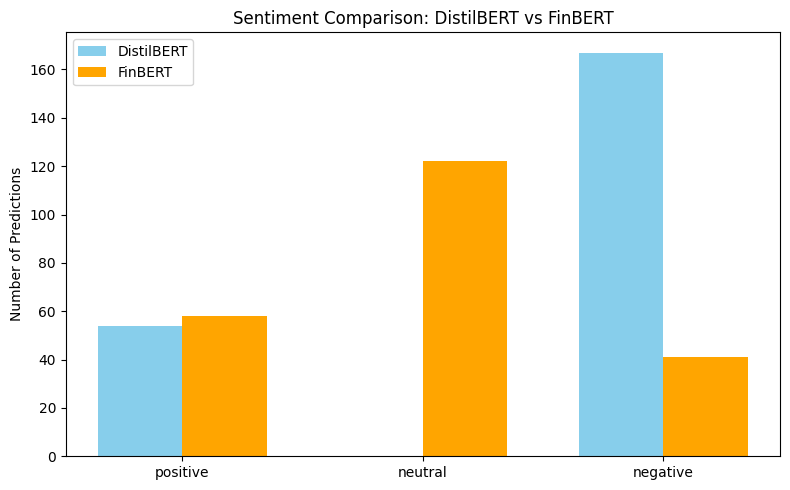

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Fix case and remove invalid values
valid_labels = ['positive', 'neutral', 'negative']

# Convert to lowercase
df['sentiment_label'] = df['sentiment_label'].astype(str).str.lower()
df['finbert_label'] = df['finbert_label'].astype(str).str.lower()

# Filter only rows where both labels are valid
df_clean = df[df['sentiment_label'].isin(valid_labels) & df['finbert_label'].isin(valid_labels)]

# Step 2: Count sentiments for each model
distil_counts = df_clean['sentiment_label'].value_counts()
finbert_counts = df_clean['finbert_label'].value_counts()

# Step 3: Plot comparison
labels = ['positive', 'neutral', 'negative']
distil_vals = [distil_counts.get(label, 0) for label in labels]
finbert_vals = [finbert_counts.get(label, 0) for label in labels]

x = range(len(labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x, distil_vals, width=width, label='DistilBERT', color='skyblue')
plt.bar([p + width for p in x], finbert_vals, width=width, label='FinBERT', color='orange')

plt.xticks([p + width/2 for p in x], labels)
plt.ylabel("Number of Predictions")
plt.title("Sentiment Comparison: DistilBERT vs FinBERT")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Combine both sentiment results into one DataFrame
combined_df = sentiment_df.join(
    finbert_df.select("title", "finbert_label", "finbert_score"),
    on="title",
    how="inner"
)

# Convert to Pandas for easier iteration (if not already)
results_pd = combined_df.toPandas()

# Save each article to Firestore
for _, row in results_pd.iterrows():
    doc_ref = db.collection("news_sentiment").document()  # Auto-generate document ID
    doc_ref.set({
        "title": row["title"],
        "description": row["description"],
        "distilbert_sentiment": row["sentiment_label"],
        "distilbert_score": float(row["sentiment_score"]),  # Ensure float type
        "finbert_sentiment": row["finbert_label"],
        "finbert_score": float(row["finbert_score"]),
        "timestamp": firestore.SERVER_TIMESTAMP  # Auto-adds server time
    })
print(f"Saved {len(results_pd)} articles to Firestore.")

Saved 34 articles to Firestore.
